In [239]:
import matplotlib.pyplot as plt
import librosa
import numpy as np
import time
import seaborn as sns
from matplotlib import gridspec

%load_ext autoreload
%autoreload 2

from generate_audio import generate_sine_wave, generate_gaussian, normalize
from utils import plot_spectogram, plot_progression
from audio_transport import join_stfts, transport, stft, compute_optimal_map, interpolate, compute_optimal_map_lp, compute_optimal_map_unbalanced
import IPython.display as ipd
from PIL import Image, ImageDraw
from io import BytesIO

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Interpolates between two chords composed of generated sine waves. The first maps three notes to three notes and the second maps four notes to three notes.

# Gaussian Case

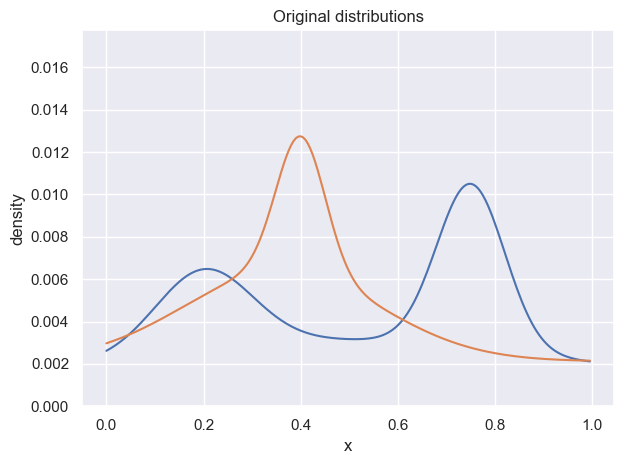

Mapping computation time: 0.8339488506317139 seconds


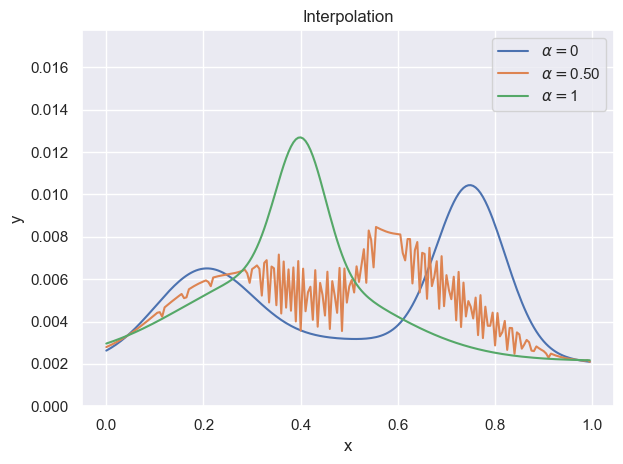

GIF saved as plots/interpolation_animation.gif


In [243]:
def gaussian_analysis(mu_1, mu_2, sigma_1, sigma_2, interp_factor = 0.5, amp_1 = 1, amp_2 = 1, N=100, titles = ["Original distributions", "Interpolation"],
                      gif = True, plot = True, gif_path = "plots/interpolation_animation.gif", algo = "original"):

    sns.set(style="darkgrid")
    mass = lambda x: np.sum(np.abs(x))
    assert len(mu_1) == len(sigma_1)
    assert len(mu_2) == len(sigma_2)
    t = np.arange(0,N)/N

    dist_a = 0
    dist_b = 0
    for i in range(len(mu_1)):
            if amp_1 == 1:
                dist_a += generate_gaussian(mu_1[i], sigma_1[i], N)
            else:
                assert len(mu_1) == len(amp_1)
                dist_a += amp_1[i] * generate_gaussian(mu_1[i], sigma_1[i], N)
    for i in range(len(mu_2)):
            if amp_2 == 1:
                dist_b += generate_gaussian(mu_2[i], sigma_2[i], N)
            else:
                assert len(mu_2) == len(amp_2)
                dist_b += amp_2[i] * generate_gaussian(mu_2[i], sigma_2[i], N)

    dist_a = normalize(dist_a)
    dist_b = normalize(dist_b)
    n, m = len(dist_a), len(dist_b)
    max_y = np.max([np.max(dist_a), np.max(dist_b)]) + 0.005
    if plot:
        plt.figure()
        plt.plot(t, dist_a)
        plt.plot(t, dist_b)
        plt.title(titles[0])
        plt.xlabel('x')
        plt.ylabel('density')
        plt.ylim(0, max_y)
        plt.tight_layout()
        plt.show()
    start_time = time.time()
    if algo == 'original':
        p = compute_optimal_map(dist_a, dist_b)
    elif algo == 'lp':
        p = compute_optimal_map_lp(dist_a, dist_b, n, m, t, t)
    elif algo == 'unbalanced':
        p = compute_optimal_map_unbalanced(dist_a, dist_b, n, m, t, t, rho= 10)
    else:
        raise ValueError("Invalid algorithm")
    print('Mapping computation time: ' + str(time.time() - start_time)  + " seconds")
    if plot:
        plt.plot(t, interpolate(p, 0, mass1=mass(dist_a), mass2=mass(dist_b)), label=r"$\alpha=$0")
        #interp = displacement_interpolation(dist_a, dist_b, np.linspace(0, 1, 100), p)
        interp = interpolate(p, interp_factor, mass1=mass(dist_a), mass2=mass(dist_b))
        #interp = normalize(interp)
        plt.plot(t, interp, label = r"$\alpha=$" +f"{interp_factor:.2f}")
        plt.plot(t, interpolate(p, 1, mass1=mass(dist_a), mass2=mass(dist_b)), label=r"$\alpha=$1")
        plt.title(titles[1])
        plt.xlabel('x')
        plt.ylabel('y')
        plt.ylim(0, max_y)
        plt.legend()
        plt.tight_layout()
        plt.show()
    if gif:
        # Generate interpolations
        x_values = np.linspace(0, 1, 100)  # Interpolation steps
        frames = []

        for i, alpha in enumerate(x_values):
            # Create the plot
            fig, ax = plt.subplots(figsize=(6, 4))
            ax.plot(t, interpolate(p, 0, mass1=mass(dist_a), mass2=mass(dist_b)), label=r"$\alpha=$0")
            interp = interpolate(p, alpha, mass1=mass(dist_a), mass2=mass(dist_b))
            #interpi = normalize(interp[i])
            ax.plot(t, interp, label=r"$\alpha=$" +f"{alpha:.2f}")
            ax.plot(t, interpolate(p, 1, mass1=mass(dist_a), mass2=mass(dist_b)), label=r"$\alpha=$1")
            ax.set_title('Interpolation with OT')
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_ylim(0, max_y)
            ax.legend()
            plt.tight_layout()

            # Convert plot to an image buffer
            buf = BytesIO()
            plt.savefig(buf, format="png")
            buf.seek(0)
            img = Image.open(buf)
            frames.append(img.copy())
            buf.close()
            plt.close()

        # Save frames as a GIF
        frames[0].save(
            gif_path,
            save_all=True,
            append_images=frames[1:],
            duration=100,  # Duration between frames in milliseconds
            loop=0  # Infinite loop
        )

        print(f"GIF saved as {gif_path}")
    return dist_a, dist_b, p

dist_a, dist_b, p = gaussian_analysis(mu_1 =[0.2, 0.5, 0.75], mu_2 = [0.4, 0.36], sigma_1= [0.1,  0.3, 0.07], sigma_2= [0.05, 0.2], amp_1 = [2, 0.7, 4],
                                      amp_2 = [1.5, 1], N = 200, algo = 'unbalanced', gif = True, plot = True, gif_path = "plots/interpolation_animation.gif")

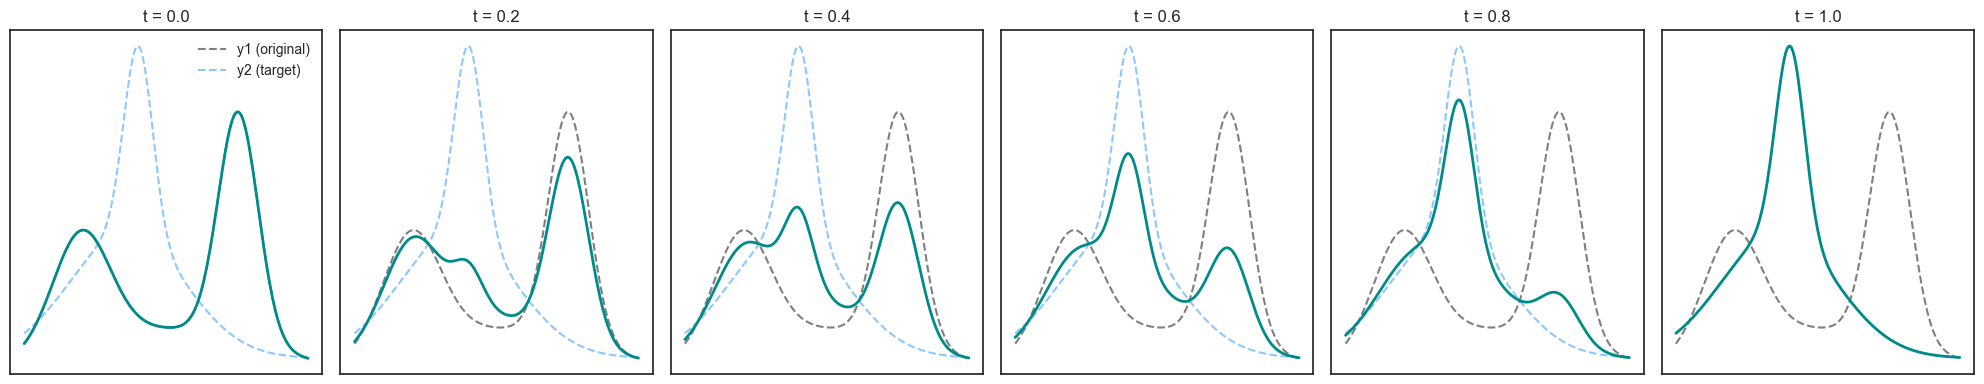

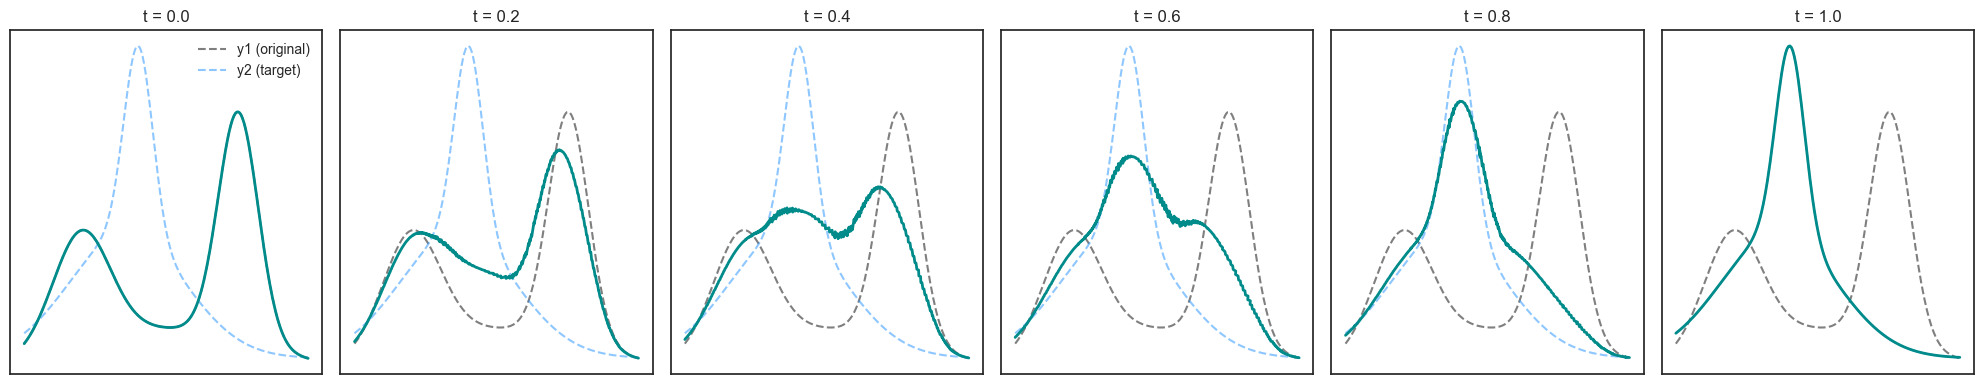

In [248]:
N = 200
t = np.arange(0,N)/N
plot_progression(t, dist_a, dist_b, interp='trivial', figsize=(20,4))
plot_progression(t, dist_a, dist_b, interp='displacement', mapping=p, figsize=(20,4))

In [114]:
# Linear interpolation
sns.set(style="darkgrid")
t = np.arange(0, 200)/200
mass = lambda x: np.sum(np.abs(x))
x_values = np.linspace(0, 1, 100)  # Interpolation steps
frames = []
max_y = np.max([np.max(dist_a), np.max(dist_b)]) + 0.005
for alpha in x_values:
    # Create the plot
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(t, interpolate(p, 0, mass1=mass(dist_a), mass2=mass(dist_b)), label=r"$\alpha=$0")
    interp_dist = (1 - alpha) *dist_a + alpha * dist_b
    ax.plot(t, interp_dist, label=r"$\alpha=$" +f"{alpha:.2f}")
    ax.plot(t, interpolate(p, 1, mass1=mass(dist_a), mass2=mass(dist_b)), label=r"$\alpha=$1")
    ax.set_title('Interpolation linear')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_ylim(0, max_y)
    ax.legend()
    plt.tight_layout()

    # Convert plot to an image buffer
    buf = BytesIO()
    plt.savefig(buf, format="png")
    buf.seek(0)
    img = Image.open(buf)
    frames.append(img.copy())
    buf.close()
    plt.close()

# Save frames as a GIF
frames[0].save(
    "plots/linear_inter.gif",
    save_all=True,
    append_images=frames[1:],
    duration=100,  # Duration between frames in milliseconds
    loop=0  # Infinite loop
)

print(f"GIF saved as plots/linear_inter.gif")


GIF saved as plots/linear_inter.gif


/var/folders/tf/1s1659hs28jc69nxhytmsqz00000gn/T/ipykernel_72763/4043511509.py:24: RuntimeWarning: invalid value encountered in log
  im2 = ax[2].imshow(np.log(p_diff+ epsilon) , cmap="coolwarm")


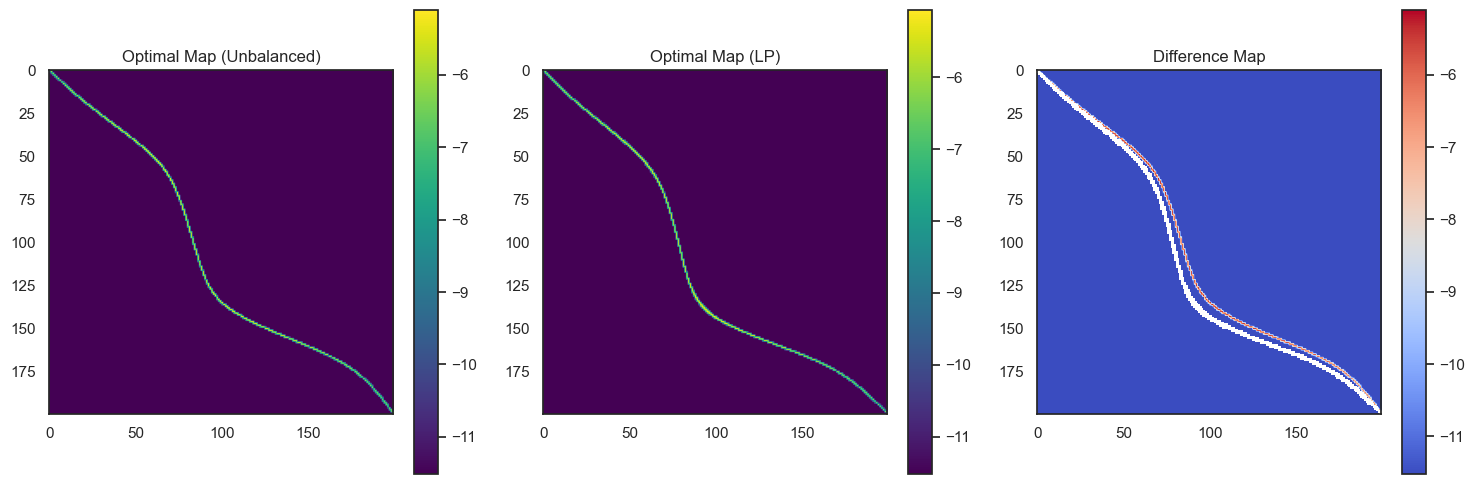

In [247]:
sns.set(style="white")
N = 200
epsilon = 1e-5
x = np.linspace(0, 1, N)
# Compute optimal maps
p = compute_optimal_map_unbalanced(dist_a, dist_b, N, N, x, x, rho= 0.4)
p_lp = compute_optimal_map_lp(dist_a, dist_b, N, N, x, x)
p_diff = p - p_lp  # Difference map

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Optimal map
im0 = ax[0].imshow(np.log(p + epsilon), cmap="viridis")
ax[0].set_title("Optimal Map (Unbalanced)")
fig.colorbar(im0, ax=ax[0], orientation="vertical")

# Optimal map (LP)
im1 = ax[1].imshow(np.log(p_lp + epsilon), cmap="viridis")
ax[1].set_title("Optimal Map (LP)")

fig.colorbar(im1, ax=ax[1], orientation="vertical")

# Difference map
im2 = ax[2].imshow(np.log(p_diff+ epsilon) , cmap="coolwarm")
ax[2].set_title("Difference Map")
fig.colorbar(im2, ax=ax[2], orientation="vertical")


#fig.suptitle("Comparison of Optimal Maps", fontsize=16, y=1.02)
fig.tight_layout()

plt.show()


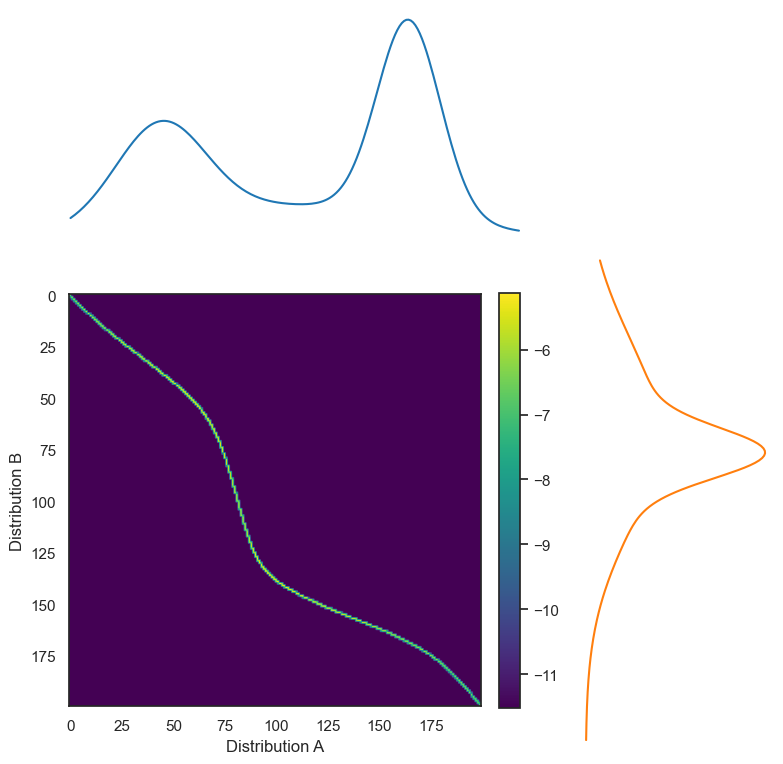

In [201]:
t = np.arange(0, N)

fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(3, 3, figure=fig)

# Main axes
ax_main = plt.subplot(gs[1:3, :2])
ax_xDist = plt.subplot(gs[0, :2], sharex=ax_main)
ax_yDist = plt.subplot(gs[1:3, 2], sharey=ax_main)

# Main image plot
im0 = ax_main.imshow(np.log(p + epsilon), cmap="viridis")
ax_main.set_xlabel("Distribution A")
ax_main.set_ylabel("Distribution B")
fig.colorbar(im0, ax=ax_main, orientation="vertical", fraction=0.046, pad=0.04)

# Add distributions
ax_xDist.plot(t, dist_a, color = '#1f77b4')
ax_xDist.axis('off')  # Hide x ticks
ax_yDist.plot(dist_b, t, color = '#ff7f0e')
ax_yDist.axis('off')  # Hide y ticks
ax_yDist.set_ylim(ax_main.get_ylim())

# Adjust layout
#fig.suptitle("Optimal Transport Map", fontsize=16, y=1.02)
fig.tight_layout()
plt.show()

# Sound Data

Computing optimal mapping


/Users/constouille/Documents/GitHub/Optimal_Audio_Transport/audio_transport/lib/python3.10/site-packages/ot/backend.py:1375: RuntimeWarning: invalid value encountered in log
  value = np.sum(p * np.log(p / q + eps))
/Users/constouille/Documents/GitHub/Optimal_Audio_Transport/audio_transport/lib/python3.10/site-packages/ot/unbalanced/_lbfgs.py:112: RuntimeWarning: invalid value encountered in log
  np.log(G.sum(1) / a + 1e-16), np.ones(n)
/Users/constouille/Documents/GitHub/Optimal_Audio_Transport/audio_transport/lib/python3.10/site-packages/ot/unbalanced/_lbfgs.py:113: RuntimeWarning: invalid value encountered in log
  ) + reg_m2 * np.outer(np.ones(m), np.log(G.sum(0) / b + 1e-16))


Optimal mapping computed
Mass of signal 1: 2137.652890968579
Mass of signal 2: 2126.506760092951


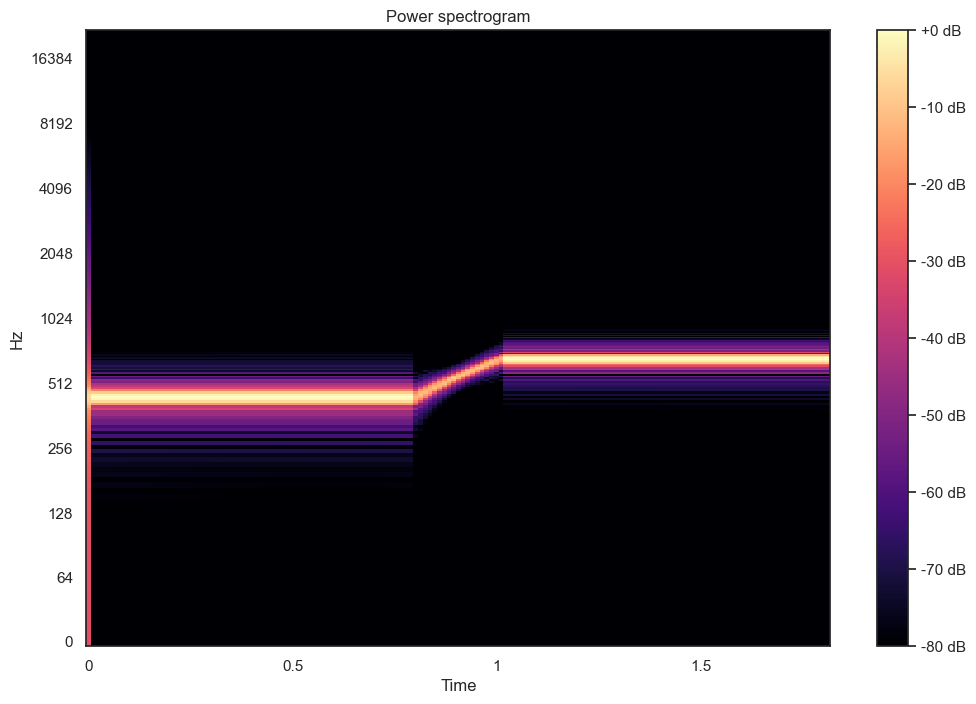

In [240]:
x1 = generate_sine_wave([440], 4, 44100)
x2 =generate_sine_wave([660], 4, 44100)
transport(x1, x2, 2, 2, 0.5, 44100, plot=3, correct_phase='vocoder', write_file='sounds/test.wav', algo = 'unbalanced', rho=1 )
ipd.Audio('sounds/test.wav')

Computing optimal mapping
Optimal mapping computed
Mass of signal 1: 1696.6713572274007
Mass of signal 2: 1270.4510219113354


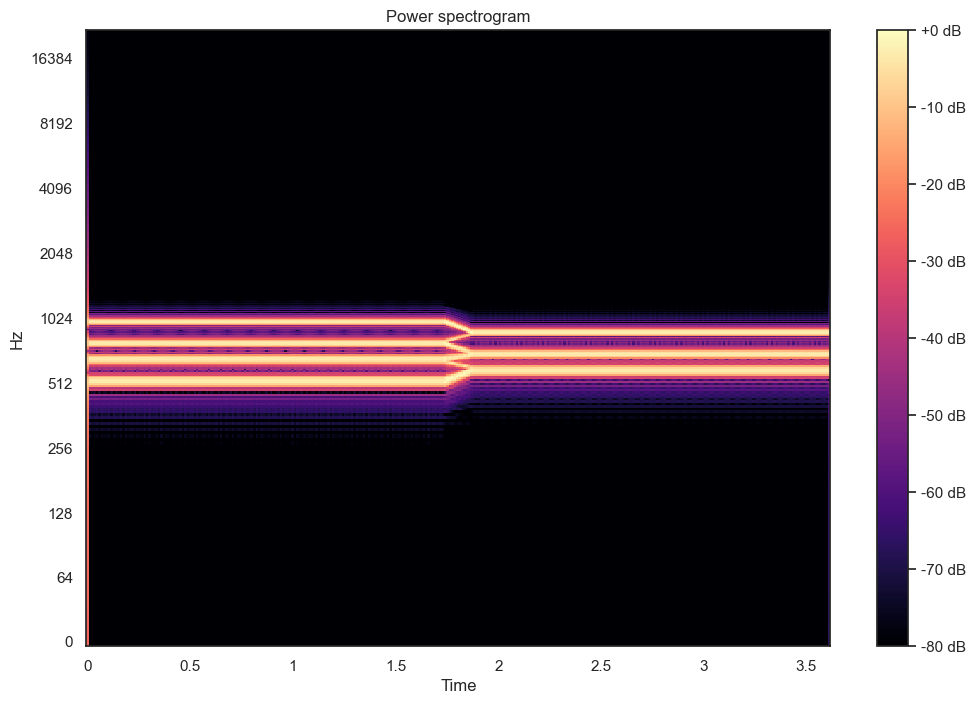

In [241]:
x1 = generate_sine_wave([523, 659, 784, 988], 4, 44100) * 0.2
x2 = generate_sine_wave([587, 698, 880], 4, 44100) * 0.2
transport(x1, x2, 4, 4, 0.3, sr = 44100, size_window= 2200, plot=3, correct_phase='vocoder', write_file='sounds/test1.wav', algo = 'original', rho=1 )
ipd.Audio('sounds/test1.wav')

Computing optimal mapping


/Users/constouille/Documents/GitHub/Optimal_Audio_Transport/audio_transport/lib/python3.10/site-packages/ot/backend.py:1375: RuntimeWarning: invalid value encountered in log
  value = np.sum(p * np.log(p / q + eps))
/Users/constouille/Documents/GitHub/Optimal_Audio_Transport/audio_transport/lib/python3.10/site-packages/ot/unbalanced/_lbfgs.py:112: RuntimeWarning: invalid value encountered in log
  np.log(G.sum(1) / a + 1e-16), np.ones(n)
/Users/constouille/Documents/GitHub/Optimal_Audio_Transport/audio_transport/lib/python3.10/site-packages/ot/unbalanced/_lbfgs.py:113: RuntimeWarning: invalid value encountered in log
  ) + reg_m2 * np.outer(np.ones(m), np.log(G.sum(0) / b + 1e-16))


Optimal mapping computed
Mass of signal 1: 1276.3608622503014
Mass of signal 2: 1270.4510219113354


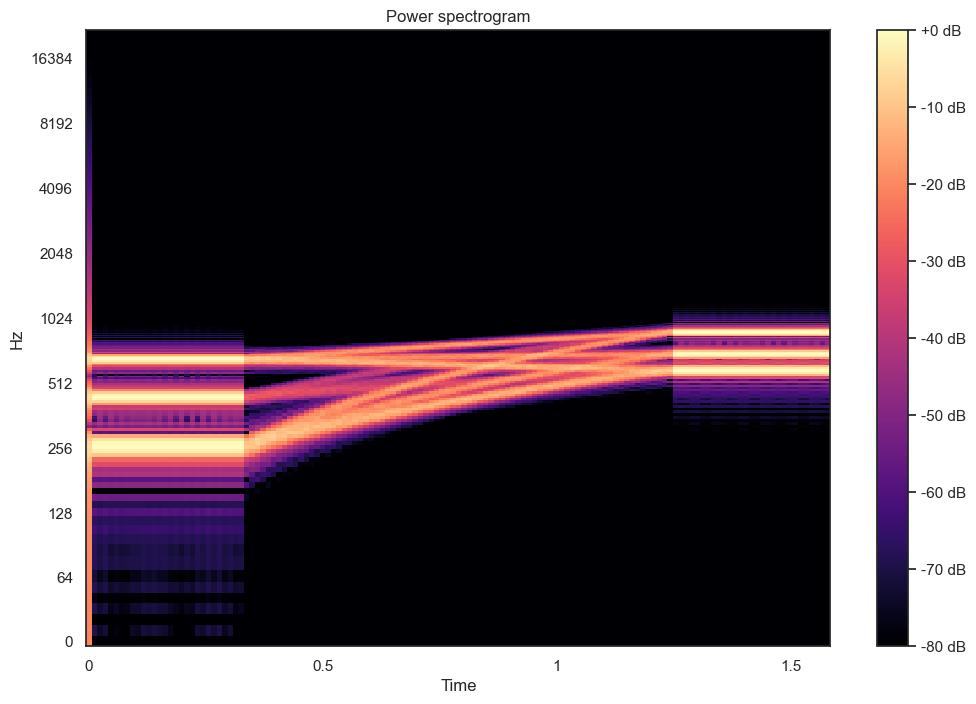

In [208]:
x1 = generate_sine_wave([261.63, 293.66*1.5, 329.63*2],  4, 44100) * 0.2
x2 = generate_sine_wave([587, 698, 880], 4, 44100) * 0.2
transport(x1, x2, 1, 1, 2, 44100, plot=3, correct_phase= 'vocoder', write_file='sounds/test2.wav', algo = 'unbalanced', rho=1 )
ipd.Audio('sounds/test2.wav')

Interpolates between two songs

Computing optimal mapping


/Users/constouille/Documents/GitHub/Optimal_Audio_Transport/audio_transport/lib/python3.10/site-packages/ot/backend.py:1375: RuntimeWarning: invalid value encountered in log
  value = np.sum(p * np.log(p / q + eps))
/Users/constouille/Documents/GitHub/Optimal_Audio_Transport/audio_transport/lib/python3.10/site-packages/ot/unbalanced/_lbfgs.py:112: RuntimeWarning: invalid value encountered in log
  np.log(G.sum(1) / a + 1e-16), np.ones(n)
/Users/constouille/Documents/GitHub/Optimal_Audio_Transport/audio_transport/lib/python3.10/site-packages/ot/unbalanced/_lbfgs.py:113: RuntimeWarning: invalid value encountered in log
  ) + reg_m2 * np.outer(np.ones(m), np.log(G.sum(0) / b + 1e-16))


Optimal mapping computed
Mass of signal 1: 1600.1903
Mass of signal 2: 3039.4194


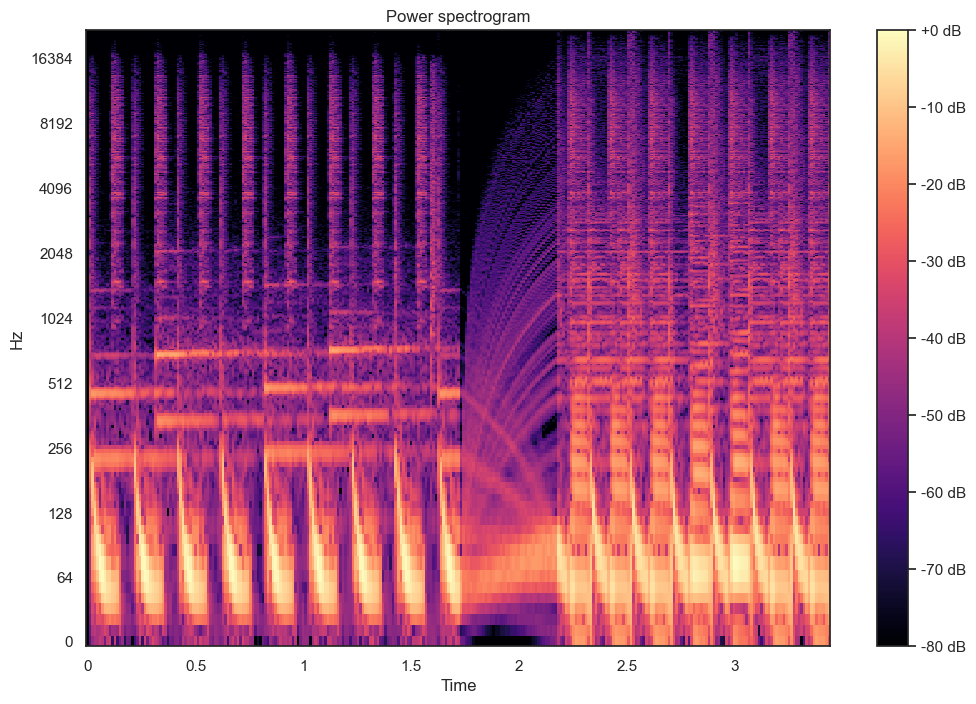

In [209]:
audio, sr = librosa.load("sounds/mallgrab_loop.wav", sr=44100)
audio2, sr2 = librosa.load("sounds/loco_loop.wav", sr=44100)
transport(audio, audio2, 4, 3, 1, 44100, plot=3, write_file='sounds/test_real_sound.wav', correct_phase='vocoder', algo = 'unbalanced', rho= 500)
ipd.Audio('sounds/test_real_sound.wav')

In [220]:
s1, S_db1, freq = stft(audio)
s2, S_db2, freq = stft(audio2)

x1, x2 = s1[:, -1], s2[:, 0]
x1 = np.abs(x1)
x2 = np.abs(x2)
x1 = normalize(x1)
x2 = normalize(x2)
n, m = len(x1), len(x2)
t1, t2 = np.arange(0, n), np.arange(0, m)
p = compute_optimal_map(x1, x2)

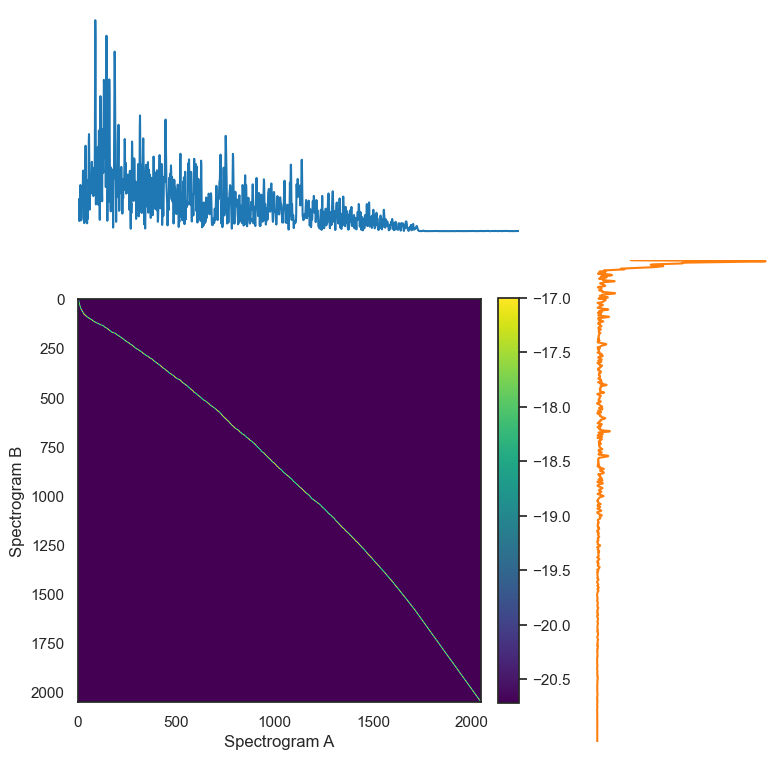

In [237]:
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(3, 3, figure=fig)
epsilon = 1e-9
# Main axes
ax_main = plt.subplot(gs[1:3, :2])
ax_xDist = plt.subplot(gs[0, :2], sharex=ax_main)
ax_yDist = plt.subplot(gs[1:3, 2], sharey=ax_main)

# Main image plot
im0 = ax_main.imshow(np.log(p + epsilon), cmap="viridis", vmax=-17)
ax_main.set_xlabel("Spectrogram A")
ax_main.set_ylabel("Spectrogram B")

fig.colorbar(im0, ax=ax_main, orientation="vertical", fraction=0.046, pad=0.04)

# Add distributions
ax_xDist.plot(t1, x1, color = '#1f77b4')
ax_xDist.axis('off')  # Hide x ticks
ax_yDist.plot(x2,t2,  color = '#ff7f0e')
ax_yDist.axis('off')  # Hide y ticks
ax_yDist.set_ylim(ax_main.get_ylim())

# Adjust layout
#fig.suptitle("Optimal Transport Map", fontsize=16, y=1.02)
fig.tight_layout()
plt.show()

Interpolates between two saxophones

Computing optimal mapping
Optimal mapping computed
Mass of signal 1: 2046.9044
Mass of signal 2: 2313.4517


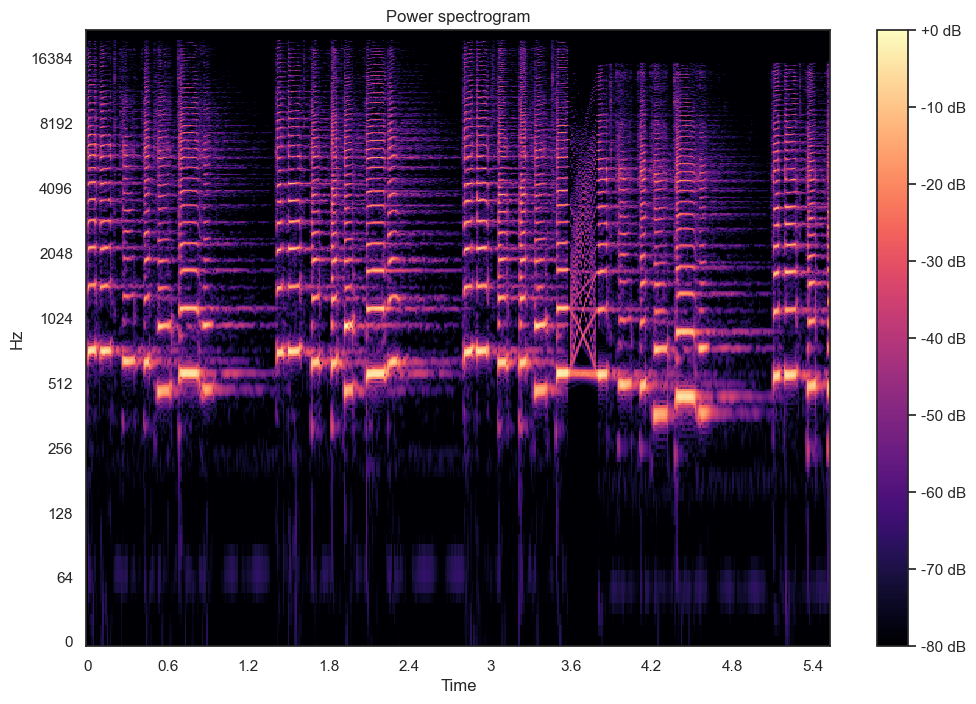

In [25]:
audio, sr = librosa.load("sounds/happy-saxophone-melody-wet_102bpm_F_major_highpitch.wav", sr=44100)
audio2, sr2 = librosa.load("sounds/happy-saxophone-melody-wet_102bpm_F_major.wav", sr=44100)
transport(audio, audio2, 8, 4, 0.5, 44100, plot=3, write_file='sounds/test_saxo.wav', correct_phase='vocoder', algo = 'unbalanced', rho=1 )
ipd.Audio('sounds/test_saxo.wav')